In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

In [2]:
df = pd.read_csv('../data.csv')

In [3]:
# Load the colormap from the csv file
cmap = pd.read_csv('../maps/color_map.csv')

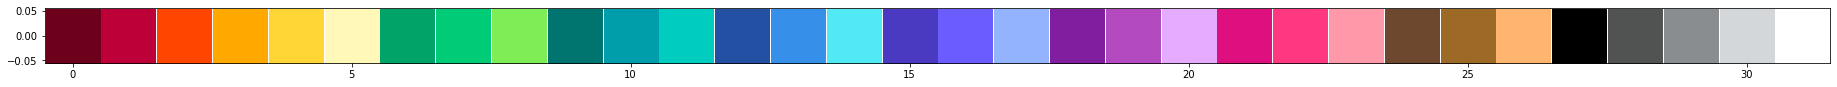

In [4]:
# Reorder the colormap using the following order:
# cmap_order = [12, 20, 25, 27, 29, 30, 3, 4, 14, 1, 2, 5, 6, 7, 10, 8, 11, 17, 15, 19, 23, 22, 24, 26, 13, 18, 28, 0, 9, 16, 21, 31]
# cmap_order_inverse = np.empty_like(cmap_order)
# for i, j in enumerate(cmap_order):
#     cmap_order_inverse[j] = i

# cmap_ordered = cmap.iloc[cmap_order, :]

# Show a color palette of the pixel_color column
plt.figure(figsize=(len(cmap), 1))
# For each color in the cmap, plot a rectangle with the color
for index, color in zip(cmap['pixel_color_int'], cmap['pixel_color']):
    plt.scatter(index, 0, marker='s', color=color, s=3000)
    plt.xlim(-0.5, len(cmap) - 0.5)
plt.show()

In [5]:
# If the color change matrix is saved, load it
if os.path.exists('./color_change_matrix.npy'):
    print('Loading color change matrix...')
    color_changes = np.load('./color_change_matrix.npy')
    print('Done!')
else:
    print('Calculating color change matrix...')
    # Create an empty matrix (n_unique_colors, n_unique_colors) to store the color changes.
    # Order: (From, To)
    color_changes = np.zeros((len(cmap), len(cmap)))

    # Create an empty matrix of the shape of the canvas (2000,2000) to store the last color at each pixel.
    # The color is represented by a single integer.
    # At the beginning, the whole canvas is white (color 31)
    last_color = np.full((2000, 2000), 31, dtype=int)

    # Iterate through the dataframe using df.itertuples().
    # Increment the color_changes matrix at [the last_color matrix at the row's pixel, the row's color index], even if the color did not change (in which case the diagonal of the change matrix is affected).
    # Lastly, set the last_color matrix at the row's pixel to the row's color index.
    # Use the cmap_order to ensure the order of the colors is correct.
    for row in tqdm(df.itertuples(), total=len(df)):
        # Remember: Order is (From, To)
        color_changes[last_color[row.x, row.y], row.color] += 1
        last_color[row.x, row.y] = row.color

    # Save the color_changes matrix
    print('Saving color change matrix...')
    np.save('./color_change_matrix.npy', color_changes)

Loading color change matrix...
Done!


In [45]:
def hex_to_rgb(hex_color):
    """
    Convert a hex color to an rgb color.
    """
    # Convert the colormap's values (currently hexadecimal) into tuples of RGB values.
    rgb_color = [int(hex_color[i+1:i+3], 16) for i in (0, 2, 4)]
    rgb_color = np.array(list(rgb_color))

    # Scale the colormap's RGB values to the range [0, 1].
    return np.array(rgb_color / 255)

In [6]:
def create_color_changes_image(color_changes, plt_cmap=None):
    if plt_cmap is None:
        plt_cmap = plt.cm.get_cmap('viridis')

    # Min-max normalize the color changes matrix.
    color_changes_scaled = (color_changes - color_changes.min()) / (color_changes.max() - color_changes.min())

    # Convert the color changes matrix to an image using the viridis colormap.
    # Do not show the plot, rather store the resulting image in a variable.

    color_changes_img = plt_cmap(color_changes_scaled)[:, :, :3]

    # Convert the colormap's values (currently hexadecimal) into tuples of RGB values.
    cmap_rgb = np.array(list(cmap['pixel_color'].apply(hex_to_rgb)))

    # Before the 0th row, add a row with the colors corresponding to the color map.
    # This is to make the color map appear on the top of the image.
    color_changes_img = np.concatenate((cmap_rgb, color_changes_img), axis=1)

    # Extend the cmap_rgb legend by one white pixel before the first entry.
    # This has to be done because we added a row to the top of the image and the color map is now one row higher.
    extended_cmap_rgb = np.concatenate((np.full((1, 1, 3), 1, dtype=int), cmap_rgb), axis=0)

    # Transpose the extended cmap_rgb to make it horizontal.
    extended_cmap_rgb = extended_cmap_rgb.transpose(1, 0, 2)

    # Before the 0th column, add a column with the colors corresponding to the color map.
    # This is to make the color map appear on the left of the image.
    color_changes_img = np.concatenate((extended_cmap_rgb, color_changes_img), axis=0)

    # Add an alpha channel to the image.
    color_changes_img = np.concatenate((color_changes_img, np.full((color_changes_img.shape[0], color_changes_img.shape[1], 1), 1, dtype=int)), axis=2)

    # Set the alpha value of the pixel at (0, 0) to 0.
    color_changes_img[0, 0, 3] = 0

    return color_changes_img

In [7]:
def show_color_changes_image(color_changes_img, fig_ax_tuple=None, save_as=None):
    # Show the color changes matrix
    if fig_ax_tuple is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig, ax = fig_ax_tuple

    ax.set_facecolor('white')
    fig.set_facecolor('white')

    # Display a red cross at (0, 0)
    ax.plot([-0.5, 0.5], [-0.5, 0.5], color='red', linewidth=1)
    ax.plot([-0.5, 0.5], [0.5, -0.5], color='red', linewidth=1)

    ax.imshow(color_changes_img)

    # Show the x-axis at the top
    ax.xaxis.tick_top()

    # Remove the ricks
    ax.set_xticks([])
    ax.set_yticks([])

    # Add axis descriptions ('from' and 'To') according to the above definition
    # The xlabel is displayed at the top of the image
    ax.set_ylabel('From')
    ax.set_xlabel('To')
    ax.xaxis.set_label_position('top')

    # Draw two lines separating the color map from the color changes matrix.
    ax.plot([0.5, len(cmap)+0.5], [0.5, 0.5], color='white', linewidth=1)
    ax.plot([0.5, 0.5], [0.5, len(cmap)+0.5], color='white', linewidth=1)

    # Save the image as an svg file.
    if save_as is not None:
        fig.savefig(save_as, dpi=1000)

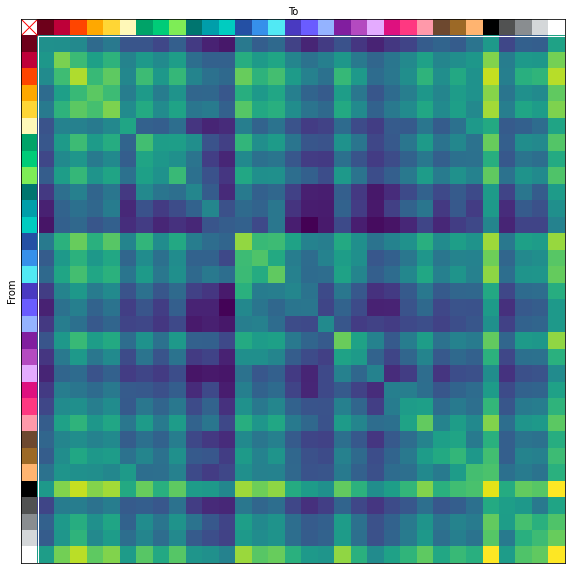

In [8]:
# Show the log of the transition matrix
show_color_changes_image(create_color_changes_image(np.log(color_changes)))

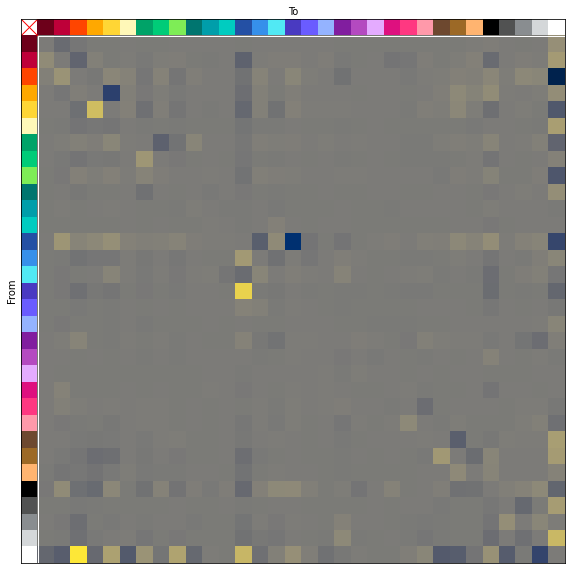

In [9]:
# Calculate the symmetry difference between the color changes matrix and its transpose.
symmetry_difference_matrix = color_changes - color_changes.T

# Min-Max-Normalize the symmetry difference matrix.
symmetry_difference_matrix_scaled = (symmetry_difference_matrix - symmetry_difference_matrix.min()) / (symmetry_difference_matrix.max() - symmetry_difference_matrix.min())

plt_cmap = plt.cm.get_cmap('cividis')

# Show the differences in symmetry
show_color_changes_image(create_color_changes_image(symmetry_difference_matrix_scaled, plt_cmap=plt_cmap))

100%|██████████| 99/99 [00:00<00:00, 49621.90it/s]


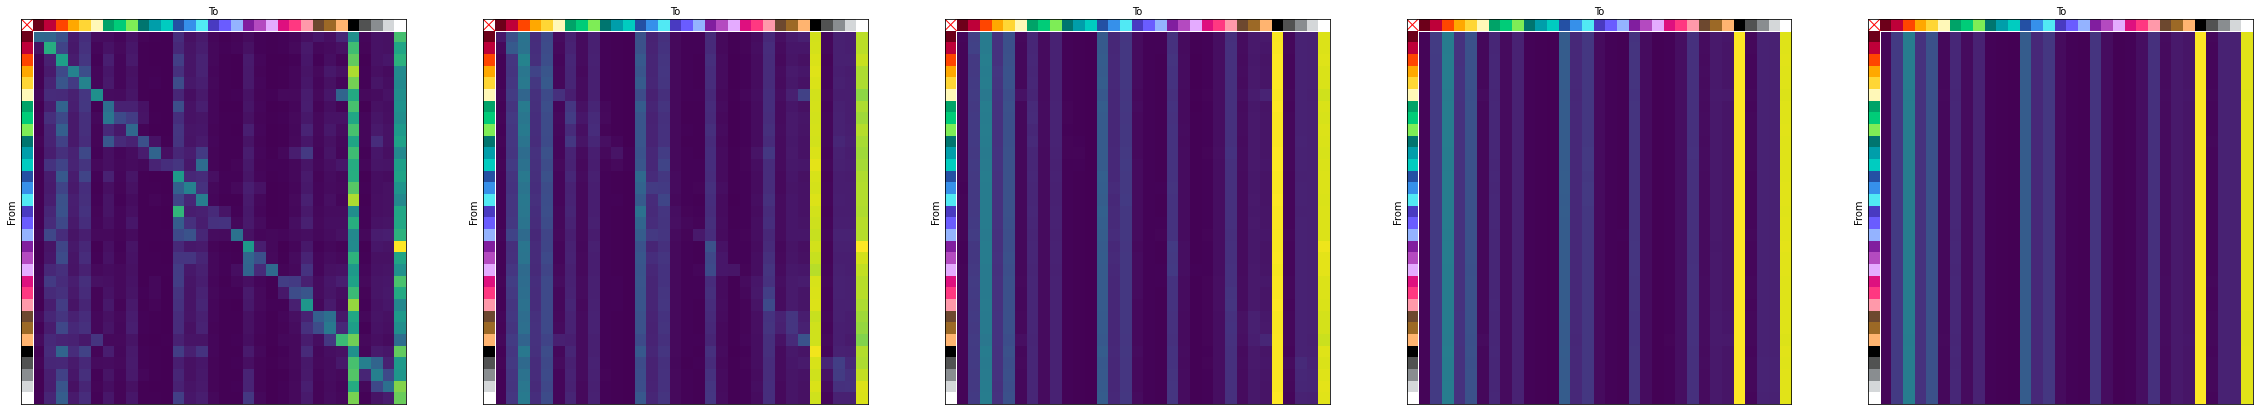

In [10]:
# Scale the color_changes matrix such that the 'to' axis is normalized to sum up to 1.
# This converts the color changes matrix into a probability matrix.
color_changes_scaled = color_changes / color_changes.sum(axis=1, keepdims=True)

# Simulate the evolution of color changes by multiplying the color changes matrix with itself.
# This is equivalent to the evolution of the color changes matrix.
# Repeat the evolution for 100 times.
color_changes_evolution = np.zeros((len(cmap), len(cmap), 100))

# The 0th element is the color changes matrix.
color_changes_evolution[:, :, 0] = color_changes_scaled

for i in tqdm(range(1, 100)):
    color_changes_evolution[:, :, i] = np.dot(color_changes_evolution[:, :, i-1], color_changes_scaled)

# Now plot the first 5 color changes evolution steps with the helper functions above.
fig, axes = plt.subplots(1, 5, figsize=(40, 8))
for i in range(5):
    show_color_changes_image(create_color_changes_image(color_changes_evolution[:, :, i]), fig_ax_tuple=(fig, axes[i]))

In [11]:
# The final distribution of colors is the product of the color changes matrix with itself.
# A good estimation is the last element of the color changes evolution matrix.
color_changes_evolution_final_distribution = color_changes_evolution[:, :, 99]

In [12]:
# Compute the total color distribution of every pixel placed from the dataframe.
all_color_changes_final_distribution = np.histogram(np.array(df['color']), bins=np.arange(33))[0]

In [13]:
f'The distributions deviate by {np.mean(all_color_changes_final_distribution/np.sum(all_color_changes_final_distribution) - color_changes_evolution_final_distribution[0, :]):.1e}'

'The distributions deviate by 1.1e-17'

In [65]:
# Read the final canvas file.
final_canvas = np.load('./color_changes_final_canvas.npy')

# Convert the color indices to RGB values using the rgb color map.
cmap_rgb = np.array(list(cmap['pixel_color'].apply(hex_to_rgb)))

# Apply the colormap to the two dimensional array.
final_canvas_rgb = cmap_rgb[final_canvas]

# Compute the color distribution of the final canvas.
final_canvas_color_distribution = np.histogram(final_canvas.flatten(), bins=np.arange(33))[0]

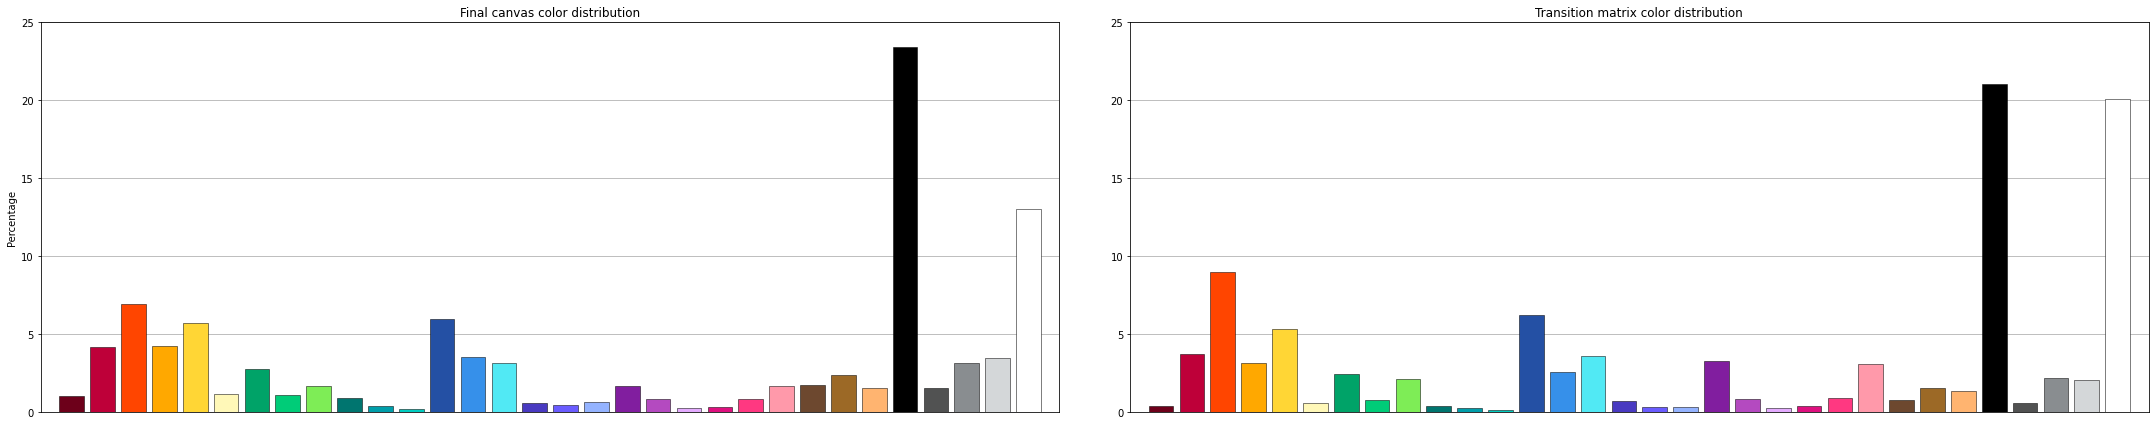

In [80]:
# Plot two distribution side by side.
# Show the distribution of colors in a regular bar plot and draw a faint outline around each bar.
# Scale the values from [0, 1] to [0, 100].

fig, (ax_final_canvas, ax_transition_matrix) = plt.subplots(1, 2, figsize=(30, 6))
fig.tight_layout(w_pad=4)

ax_final_canvas.bar(range(len(cmap)), final_canvas_color_distribution/np.sum(final_canvas_color_distribution)*100, color=cmap['pixel_color'], edgecolor='black', linewidth=0.5, zorder=3)
ax_final_canvas.set_xlim([-1, len(cmap)]); ax_final_canvas.set_ylim(0, 25)
ax_final_canvas.set_xticks([]); ax_final_canvas.grid(axis='y', zorder=1); ax_final_canvas.set_title('Final canvas color distribution'); ax_final_canvas.set_ylabel('Percentage')

ax_transition_matrix.bar(range(len(cmap)), color_changes_evolution_final_distribution[0, :]*100, color=cmap['pixel_color'], edgecolor='black', linewidth=0.5, zorder=3)
ax_transition_matrix.set_xlim([-1, len(cmap)]); ax_transition_matrix.set_ylim(0, 25)
ax_transition_matrix.set_xticks([]); ax_transition_matrix.grid(axis='y', zorder=1); ax_transition_matrix.set_title('Transition matrix color distribution');